<a href="https://colab.research.google.com/github/kantasis/SalesAnalysis/blob/main/Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Analysis Notebook



## 1. Load the data

In [297]:
# Parameters:
mountpoint_rpath = '/content/drive'
dataset_rfile = f'{mountpoint_rpath}/MyDrive/techpro/final/adjusted_retail_sales_data_v2.csv'

# Imports:
from google.colab import drive
drive.mount(mountpoint_rpath)

import pandas as pd
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [298]:
rawData_df = pd.read_csv(
  dataset_rfile,
  # dataset_url,
  # index_col=0,
)
N, M = rawData_df.shape

## 2. First Impressions

In [299]:
# Review the first lines of the data
rawData_df.head(10)

,SalesDate,ProductCategory,SalesAmount,CustomerAge,CustomerGender,CustomerLocation,ProductRatings
0,2023-10-15,Home Appliances,609,22,Male,USA,4
1,2023-09-16,Clothing,1367,22,Female,Australia,5
2,2022-09-06,Electronics,1736,22,Male,UK,2
3,2023-02-24,Female,1838,35,Clothing,India,2
4,2022-09-24,Home Appliances,1829,35,Male,UK,5
5,2023-08-15,Clothing,379,22,Male,Australia,3
6,2022-07-19,Clothing,1459,35,Male,USA,5
7,12-09-2023,Clothing,1656,35,Male,USA,3
8,2022-08-07,Electronics,366,35,Male,Canada,2
9,2023-12-04,Clothing,1875,35,Female,UK,10


In [300]:
# Review column-wise data
rawData_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SalesDate         1000 non-null   object
 1   ProductCategory   1000 non-null   object
 2   SalesAmount       1000 non-null   object
 3   CustomerAge       1000 non-null   int64 
 4   CustomerGender    1000 non-null   object
 5   CustomerLocation  998 non-null    object
 6   ProductRatings    1000 non-null   object
dtypes: int64(1), object(6)
memory usage: 54.8+ KB


Already we can see the following changes need to be made
- `SalesDate` column should be cast to date dtype
- Similarly `SalesAmount` and `CustomerAge` needs to be numeric, not object
- Column `ProductRatings` is apparently ordinal so we'd best convert it to numeric
- `ProductCategory`, `CustomerGender`, and `CustomerLocation` look like they are categorical so one-hot encoding sounds appropriate


## 3. Data cleaning and Preparation

In [301]:
# Let's create a 'workpiece' dataframe
df = rawData_df.copy()

Starting with the `SalesDate` column: we can see that most of the dates follow the '%Y-%m-%d' format. There are a few however that do not. Furthermore those dates are ambiguous as to their formatting.

Following the 'Garbage In - Garbage Out' concept, we opt to drop those rows.

In [302]:
# SalesDate

df['SalesDate'] = pd.to_datetime(
  df['SalesDate'],
  format='%Y-%m-%d',
  errors="coerce"
)

# Check to see if there are any dates that don't follow the format
validRows_mask = ~ df['SalesDate'].isna()
invalidRows_cnt = (~ validRows_mask).sum()
print(f"Dropping {invalidRows_cnt} rows with bad date format")

df = df[ validRows_mask ]

# Also let's use this column as the index of the dataframe
df = df.set_index('SalesDate')
df = df.sort_index()



Dropping 3 rows with bad date format


The `SalesAmount` should be straightforward. There are some rows that do not have a numeric representation which we will again drop

In [303]:
# SalesAmount
df['SalesAmount'] = pd.to_numeric(
  df['SalesAmount'],
  errors="coerce"
)

# Check if any rows have had invalid values
validRows_mask = ~ df['SalesAmount'].isna()
invalidRows_cnt = (~ validRows_mask).sum()
print(f"Dropping {invalidRows_cnt} rows with bad sales value")

# 6 more rows have invalid values for numeric conversion.
df = df[ validRows_mask ]

Dropping 6 rows with bad sales value


Checking the `CustomerAge` column

In [304]:
# CustomerAge
df['CustomerAge'] = pd.to_numeric(
  df['CustomerAge'],
  errors="coerce"
)
validRows_mask = ~ df['CustomerAge'].isna()
invalidRows_cnt = (~ validRows_mask).sum()
print(f"Found {invalidRows_cnt} rows with invalid age")

# Looks like there are no invalid ages
df['CustomerAge'].describe()


# However we can see that the range of the values is from 2 to 200 years

print(f"Values go from {df['CustomerAge'].min()} to {df['CustomerAge'].max()}")

# How many rows have odd ages?
underage_mask = df['CustomerAge'] < 18
print(f"{underage_mask.sum()} purchases refer to underage clients")
overage_mask = df['CustomerAge'] > 100
print(f"{overage_mask.sum()} purchases refer to overage clients")

# Looks like it's npt that many
validRows_mask = (~ underage_mask) & (~ overage_mask)
df = df[validRows_mask]


Found 0 rows with invalid age
Values go from 2 to 200
1 purchases refer to underage clients
7 purchases refer to overage clients


In [305]:
# Let's also check the distribution of ages among the dataset
df['CustomerAge'].value_counts()

# Apparently the sales center around 2 ages: 22 and 35.
# There are 3 more sales at other ages but they don't seem to be unreasonable

22     505
35     475
100      1
95       1
20       1
Name: CustomerAge, dtype: int64

Checking the `ProductRatings` column

In [306]:
# ProductRatings
print(df['ProductRatings'].value_counts())

# From the looks of it, the ratings go from 1 to 5
# and there are 3 outlier values which are reasonably inferable
# invalidRows_mask = df['ProductRatings'].isin(['10','two','one'])

# Fix the invalid rows
df['ProductRatings'] = df['ProductRatings'].replace(['10','two','one'],[5,2,1])

# Cast the column to numeric
df['ProductRatings'] = pd.to_numeric(
  df['ProductRatings'],
  errors="coerce"
)


3      214
2      206
1      193
4      187
5      180
two      1
one      1
10       1
Name: ProductRatings, dtype: int64


Check the `ProductCategory` column

In [307]:
# ProductCategory
print(df['ProductCategory'].value_counts())
# print(df['CustomerGender'].value_counts())

# There looks to be an invalid row so
invalidRows_mask = df['ProductCategory'] == 'Female'
print(df[invalidRows_mask])

# It looks like ProductCategory and CustomerGender got swapped
# Let's swap them back

temp = df.loc[invalidRows_mask,'ProductCategory']
df.loc[invalidRows_mask,'ProductCategory'] = df.loc[invalidRows_mask,'CustomerGender']
df.loc[invalidRows_mask,'CustomerGender'] = temp


Electronics        349
Clothing           322
Home Appliances    311
Female               1
Name: ProductCategory, dtype: int64
           ProductCategory  SalesAmount  CustomerAge CustomerGender  \
SalesDate                                                             
2023-02-24          Female       1838.0           35       Clothing   

           CustomerLocation  ProductRatings  
SalesDate                                    
2023-02-24            India               2  


In [308]:
# CustomerLocation
print(df['CustomerLocation'].value_counts())

# Those counts look right, nothing to do here

USA          203
UK           199
Canada       196
India        164
Australia    113
Japan        106
Name: CustomerLocation, dtype: int64


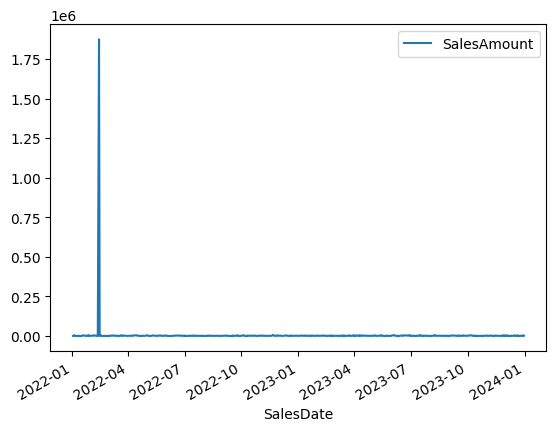

In [309]:
# Let's do a basic visualization of the data
data_ser = df.groupby(['SalesDate'])[['SalesAmount']].sum()
ax = data_ser.plot()

(0.0, 8010.294280811603)

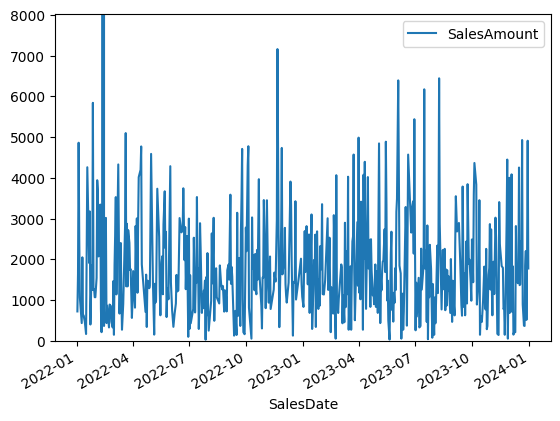

In [310]:
# There looks to be a huge outlier so let's try again:
ax = data_ser.plot()

# arbitrarily pick a max value to visualize
threshold_f = data_ser.std().values[0] / 10
ax.set_ylim(0, threshold_f)


In [311]:
# Print the row that is such an outlier
threshold_f = df['SalesAmount'].max() * 0.99
outlier_mask = df['SalesAmount'] > threshold_f
df[outlier_mask]

,ProductCategory,SalesAmount,CustomerAge,CustomerGender,CustomerLocation,ProductRatings
SalesDate,,,,,,
2022-02-13,Electronics,1875000.0,22,Male,Australia,2


In [312]:
# The outlier does not look to be like that because of data corruption.
# However, since its value is so out of the ordinary, we'd better exclude it from our analysis
df = df[~outlier_mask]

In [313]:
# Let's store the dataset to a different dataframe
dataset_df = df

Let's review the values in each column

In [314]:
# Briefly give some info on the cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 982 entries, 2022-01-02 to 2023-12-31
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ProductCategory   982 non-null    object 
 1   SalesAmount       982 non-null    float64
 2   CustomerAge       982 non-null    int64  
 3   CustomerGender    982 non-null    object 
 4   CustomerLocation  980 non-null    object 
 5   ProductRatings    982 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 53.7+ KB


In [315]:
# Some additional info on the numeric columns
df.describe()

,SalesAmount,CustomerAge,ProductRatings
count,982.000000,982.000000,982.000000
mean,981.268839,28.439919,2.954175
std,538.641279,7.207847,1.388367
min,22.000000,20.000000,1.000000
25%,512.500000,22.000000,2.000000
50%,987.000000,22.000000,3.000000
75%,1428.000000,35.000000,4.000000
max,1994.000000,100.000000,5.000000


We've had to remove 18 records which represents 1.8% of the dataset's rows.
It would be safe to assume that no significant amount of information has been lost to the cleanup

## 4. Basic Visualization

In [316]:
dataset_df.columns

Index(['ProductCategory', 'SalesAmount', 'CustomerAge', 'CustomerGender',
       'CustomerLocation', 'ProductRatings'],
      dtype='object')

In [318]:

def plotColumn(df, column_name):
  labels_strLst=[]
  for column_val, groupedData_df in df.groupby(column_name):

    # Instead of daily data, aggregate the dates into months for better overview
    monthlyData_df = groupedData_df.resample('M')['SalesAmount'].sum()
    ax = monthlyData_df.plot(
      x='SalesDate',
      y='SalesAmount',
      # label=column_val,
      # ax=axes_lst[i]
      figsize=(16,4)
    )
    labels_strLst.append(column_val)

  ax.legend(labels_strLst)
  # ax.set_title(column_name)
  return ax



Electronics        348
Clothing           323
Home Appliances    311
Name: ProductCategory, dtype: int64

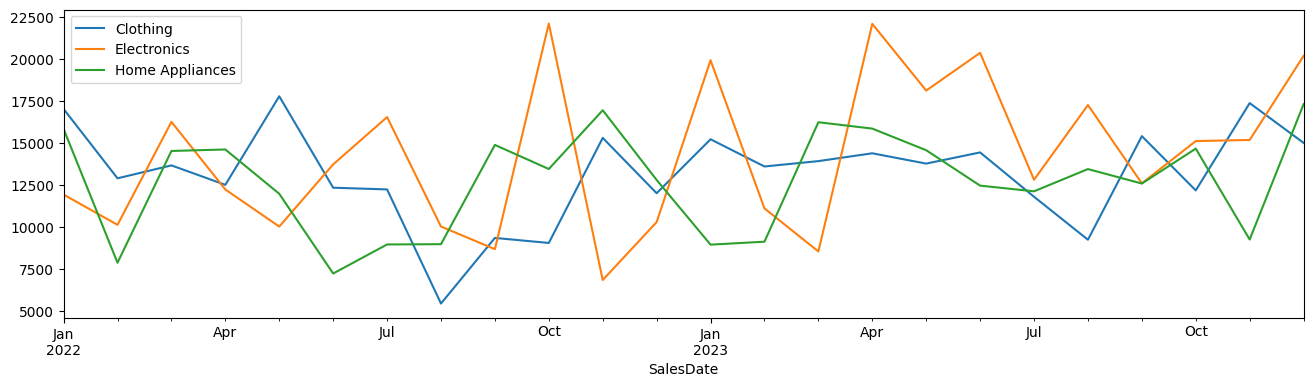

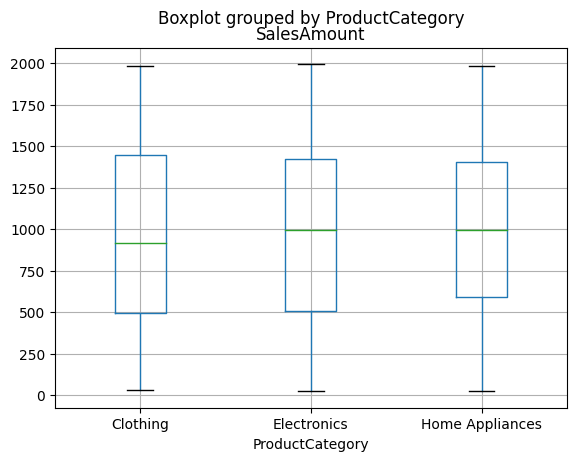

In [330]:
# Let's visualize ProductCategory
ax = plotColumn(df, 'ProductCategory')

# And let's review a boxplot of the values by
df.boxplot(column='SalesAmount', by='ProductCategory')

df['ProductCategory'].value_counts()

As we can see from the time series, no clear trend (upward or downward) is evident.

The boxplot shows that the 3 categories have similar metrics (mean, variance, min, max)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


20       1
22     504
35     475
95       1
100      1
Name: CustomerAge, dtype: int64

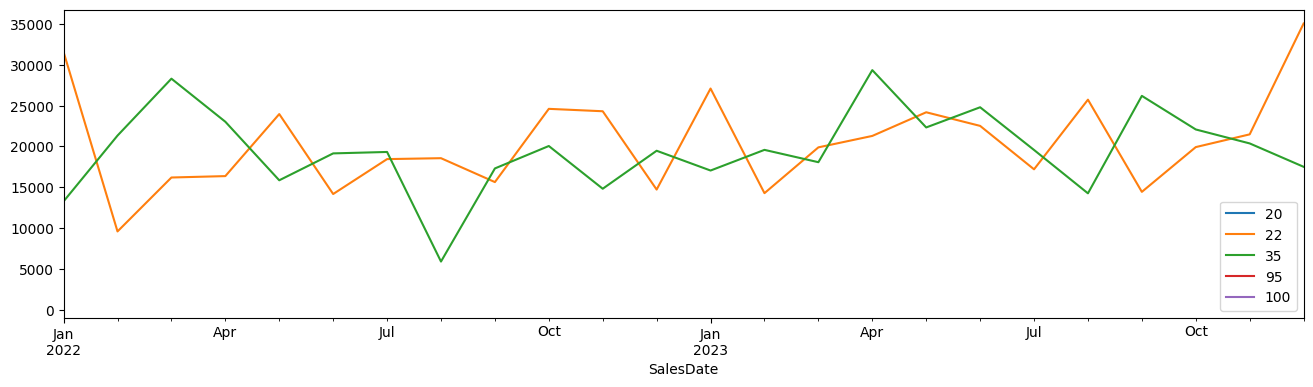

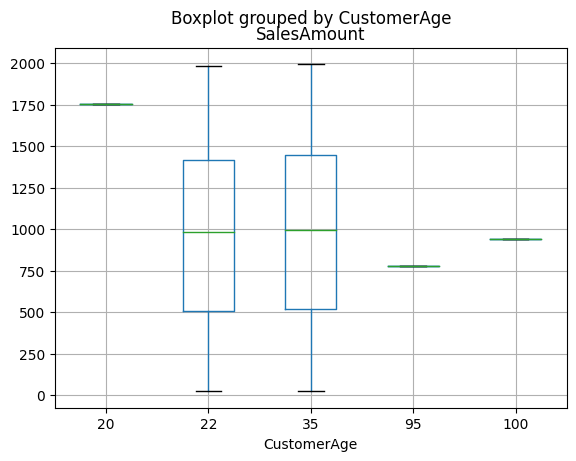

In [331]:
# CustomerAge Visualization
ax = plotColumn(df, 'CustomerAge')

# And let's review a boxplot of the values by
df.boxplot(column='SalesAmount', by='CustomerAge')

df['CustomerAge'].value_counts().sort_index()

Like we've seen in the data cleaning step, there are 2 main ages in the dataset with similar spending habits (as per the boxplot). The other 3 ages other than being 'singles' do have somewhat different values but not overtly

The time series data again seems to show no trend or periodicity

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


Male              478
Female            477
Unknown            22
Non-binary          4
Did not answer      1
Name: CustomerGender, dtype: int64

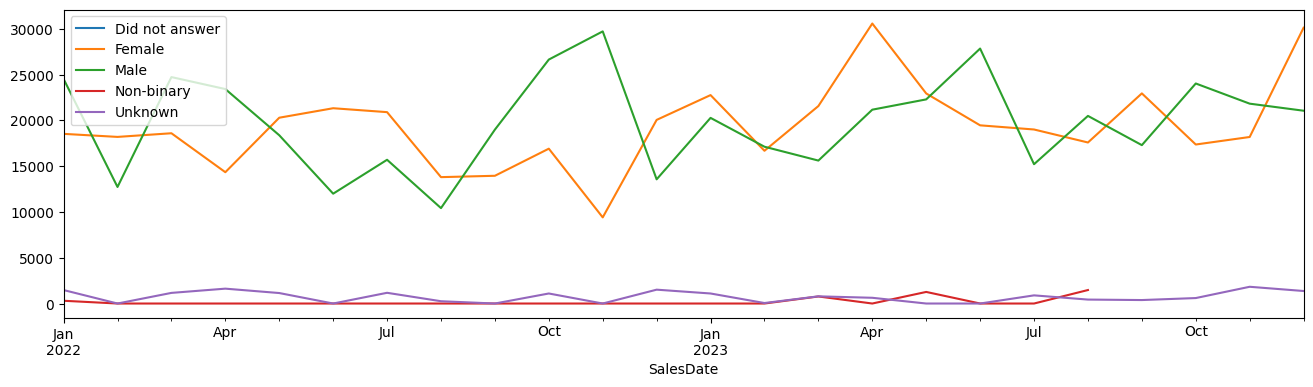

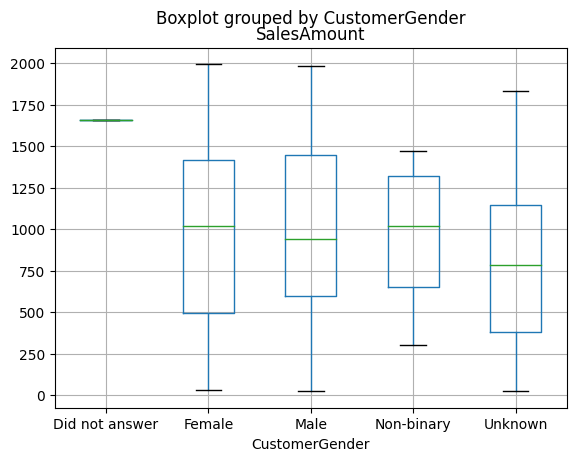

In [332]:
# CustomerAge Visualization
ax = plotColumn(df, 'CustomerGender')

# And let's review a boxplot of the values by
df.boxplot(column='SalesAmount', by='CustomerGender')

df['CustomerGender'].value_counts()

USA          203
UK           199
Canada       196
India        164
Australia    112
Japan        106
Name: CustomerLocation, dtype: int64

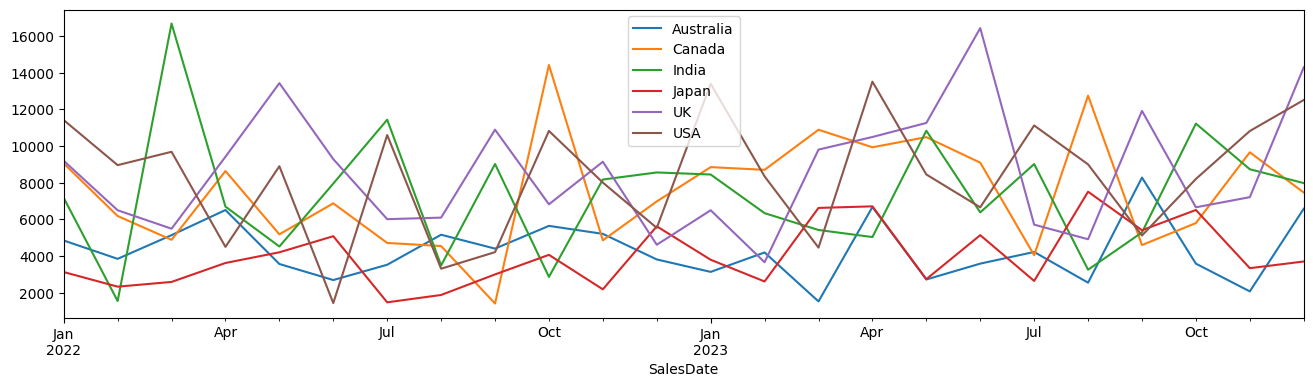

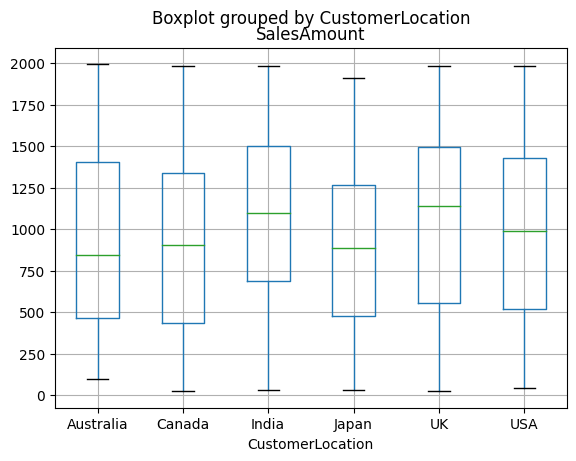

In [333]:
# CustomerLocation Visualization
ax = plotColumn(df, 'CustomerLocation')

# And let's review a boxplot of the values by
df.boxplot(column='SalesAmount', by='CustomerLocation')

df['CustomerLocation'].value_counts()

What is interesting here is that even though the sales look to be similar for all locations, each country has vastly different populations and hence market size. It would be a safe interpretation that the market capitalization of Japan, with 35mil people is vastly greater than the market capitalization of India with a population of 1.4 billion

3    214
2    206
1    194
4    187
5    181
Name: ProductRatings, dtype: int64

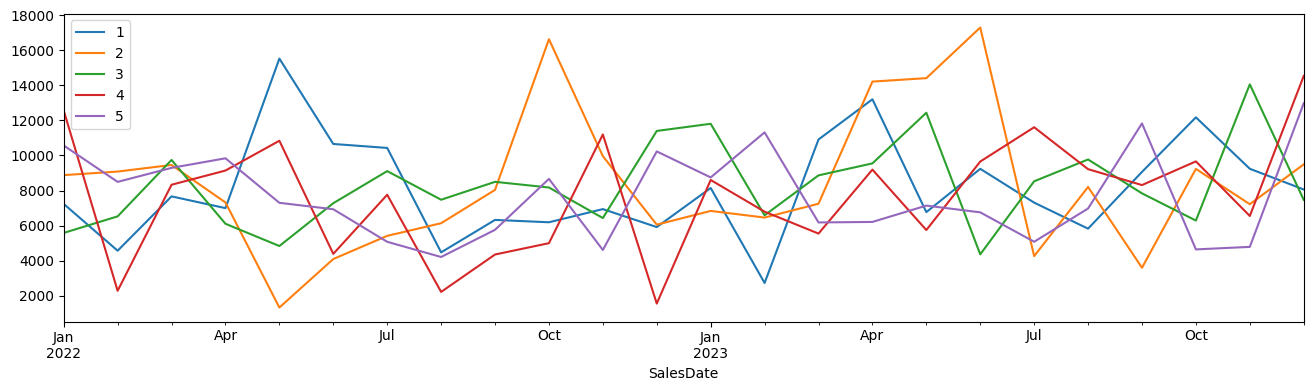

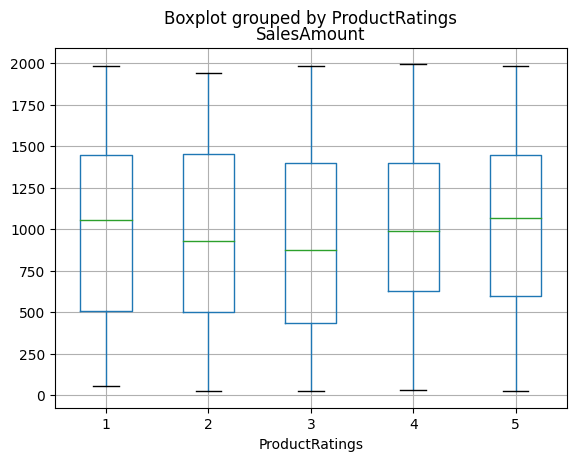

In [326]:
# ProductRatings Visualization
ax = plotColumn(df, 'ProductRatings')

# And let's review a boxplot of the values by
df.boxplot(column='SalesAmount', by='ProductRatings')

df['ProductRatings'].value_counts()

What is interesting here is that sales amounts are quite similar across the entire spectrum of product ratings.